In [2]:
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Input, BatchNormalization, LSTM, TimeDistributed, Conv2D, Dropout, ConvLSTM2D, MaxPooling2D
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing import image_dataset_from_directory
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from cv2 import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import models.TimeDistributedImageDataGenerator

%load_ext tensorboard
%matplotlib inline

In [9]:
img_size = (112,112)
base_learning_rate = 1e-6

In [10]:
datagen = TimeDistributedImageDataGenerator.TimeDistributedImageDataGenerator(time_steps=10, preprocessing_function=preprocess_input)
train_data = datagen.flow_from_directory(
    './dataset/train/', 
    target_size= img_size, 
    batch_size=8,
    shuffle=True
    )

val_data = datagen.flow_from_directory(
    './dataset/val/', 
    target_size=img_size, 
    batch_size=8, 
    shuffle=True
    )

test_data = datagen.flow_from_directory(
    './dataset/test/', 
    target_size=img_size, 
    batch_size=8, 
    shuffle=True
    )

Found 40200 images belonging to 8 classes.
Found 3450 images belonging to 8 classes.
Found 2220 images belonging to 8 classes.


In [11]:
class_names = list(train_data.class_indices)
num_classes = len(class_names)

In [8]:
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size + (3,)))
    
    #lock convolutional layers
for layer in resnet50.layers:
    layer.trainable = True

model = Sequential()
model.add(TimeDistributed(resnet50, input_shape=((10,) + img_size + (3,))))
model.add(TimeDistributed(GlobalAveragePooling2D(), name='avg_pool'))
model.add(LSTM(256, return_sequences=True))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(num_classes, activation='softmax', name='predictions'))

In [ ]:
model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
model.compile(
  optimizer= Adam(learning_rate=base_learning_rate),
  loss='categorical_crossentropy',
  metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.CategoricalAccuracy()]
  )

In [8]:
log_dir = "./log_ts/tensorboard/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(
    log_dir= log_dir, 
    histogram_freq=1,
    write_grads=False
    )

earlystopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=1e-4,
    patience=30,
    restore_best_weights=True,
    verbose=1
    )

modelcheckpoints = ModelCheckpoint(
    './log_ts/checkpoints/{val_loss:.4f}-{val_accuracy:.4f}.h5',
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
    )

csvlogger = CSVLogger(
    './log_ts/log.csv'
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_lr=1e-7,
    verbose=1
    )

In [14]:
history = model.fit(
    train_data,
    epochs=1,
    validation_data=val_data,
    steps_per_epoch= 40200//8,
    validation_steps= 3450//8
    )

5025/5025 [==============================] - 4321s 855ms/step - loss: 1.3796e-04 - precision_1: 1.0000 - recall_1: 1.0000 - categorical_accuracy: 1.0000 - val_loss: 0.2344 - val_precision_1: 0.9797 - val_recall_1: 0.9796 - val_categorical_accuracy: 0.9797


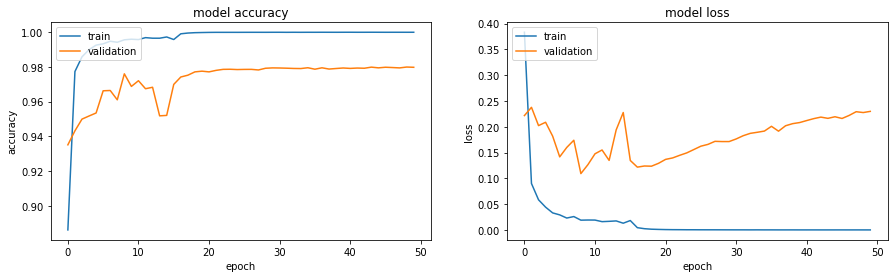

In [18]:
plt.figure(figsize=(15, 4))
plt.subplot(121),
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
model.save('./log_ts/50epoch.h5')

In [12]:
model = load_model('./log_ts/50epoch.h5')

In [ ]:
%tensorboard --logdir log2/tensorboard --host localhost --port 8888

In [15]:
test_loss, test_prec, test_rec, test_accuracy = model.evaluate(test_data)

278/278 [==============================] - 103s 369ms/step - loss: 5.7330 - precision_1: 0.6029 - recall_1: 0.5999 - categorical_accuracy: 0.6014


---